In [4]:
using JLD2, FileIO, FITSIO, FITSTables, DataFrames, CSV, PyPlot, PyCall
LogNorm = pyimport("matplotlib.colors").LogNorm
include("get_lamost_spectra.jl")
include("fitsdf.jl")
include("lines_and_grid.jl")
;

Matplotlib is building the font cache; this may take a moment.


In [5]:
lamost = FITS(f->DataFrame(f[2]), "../cats/LAMOST-dr5v3-designations-coords-gaia.fits")
lamost.G = @. lamost.phot_bp_mean_mag + 5log10(max(lamost.parallax, 0)/1000) + 5;

#battery = DataFrame()
#FITS("../cats/the-battery-stars.rc.fits") do hdus
#    battery.fn = read(hdus[2], "lamost_id")
#    battery.ra = read(hdus[2], "ra")
#    battery.dec = read(hdus[2], "dec")
#end
#battery = join(battery, lamost, on=[:ra, :dec]);

#dr2 = FITS("../cats/LAMOST-dr2-stellar.fits.gz") do hdus
#    Set(read(hdus[2], "designation"))
#end

In [6]:
fn = "random_30000_all.classified.fits"
df = join(fitsdf(fn, 2), lamost[:, [:designation, :ra, :dec, :teff, :feh, :logg, :phot_g_mean_mag, :bp_rp, :snrr, :G]], kind=:left, on=:designation)
for col in [:teff, :logg, :phot_g_mean_mag, :bp_rp, :snrr, :G]
    df[ismissing.(df[:, col]), col] .= NaN
end
;

In [7]:
lamost[lamost.designation .== "J062739.73+463634.4", :source_id]

1-element Array{Int64,1}:
 965846541808816256

## flag

In [8]:
#df.inbat = map(eachrow(df)) do row
#    row.designation in Set(battery.designation)
#end

#df.oldcat = map(eachrow(df)) do row
#    (row.designation in dr2) && (row.logg .< 3)
#end   

df.couldflag = df.EEW_err .< 0.15/3
df.flagged = df.isline .& (df.EEW .> 0.15) .& df.couldflag

df.delta_loss = map(df.loss) do loss
    minimum(loss[2:end]) - loss[1]
end
df.oldflagged = (df.delta_loss .> 25) .& (df.EEW .> 0)

println("fraction of all spectra that get flagged: ", mean(df.flagged), " (", sum(df.flagged), ")")
println("faction too noisy to be flagged: $(mean(.! df.couldflag)) ($(sum(.! df.couldflag)))")
#println("flagged $(sum(df[df.oldcat, :flagged])) including $(sum(df[df.oldcat .& df.couldflag, :flagged] .& df[df.oldcat .& df.couldflag, :inbat])) of $(sum(df[df.oldcat .& df.couldflag, :inbat])) in flaggable battery for DR2 giants")
println()

fraction of all spectra that get flagged: 0.0019399883434967117 (8428)
faction too noisy to be flagged: 0.3803928591487438 (1652562)



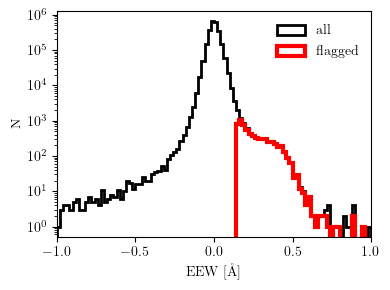

In [22]:
figure(figsize=(4,3))
r = (-1, 1)

goodfit = (df.max_best_fit_chi2 ./ length(wl_grid)) .< 2

plt.hist(df.EEW[df.couldflag .& goodfit], density=false, range=r, bins=100, histtype="step", label="all", lw=2, ec="k")
plt.hist(df.EEW[df.flagged .& goodfit], density=false, range=r, bins=100, histtype="step", label="flagged", lw=3, ec="r")
#plt.hist(-df.EEW[df.couldflag .& df.isline .& goodfit], density=false, range=[0.15,1], bins=40, label="contaminants\nupper bound", lw=3, fc="grey", zorder=-1)
xlim(-1, 1)
legend()
yscale("log")
ylabel("N")
xlabel(LaTeXString("EEW [\\AA]"))
tight_layout()
savefig("../../Desktop/EEWhist.pdf", bbox_inches="tight")

In [11]:
losses = reduce(hcat,df[df.EEW .> 0.7, :loss]);

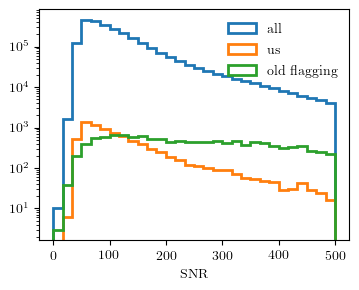

PyObject Text(0.5, 22.299550986642963, 'SNR')

In [8]:
# SNR looks good!
include("../cats/human_readable_names.jl")
figure(figsize=(4,3))
col=:snrr
range=[0,500]
plt.hist(df[df.couldflag, col], histtype="step", lw=2, label="all", range=range, bins=30)
plt.hist(df[df.flagged, col], histtype="step", lw=2, label="us", range=range, bins=30)
plt.hist(df[df.oldflagged, col], histtype="step", lw=2, label="old flagging", range=range, bins=30)
yscale("log")
legend()
xlabel("SNR")

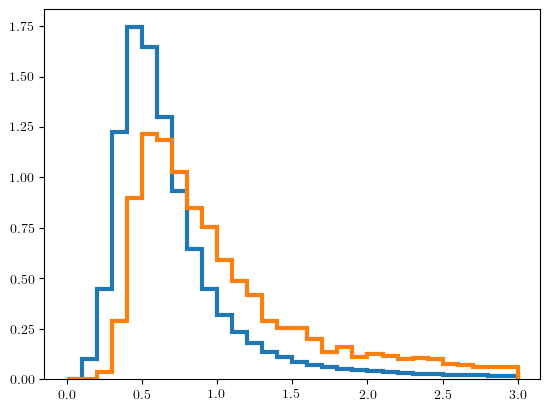

In [9]:
include("lines_and_grid.jl")
hist(df.max_best_fit_chi2 ./ length(wl_grid), range=[0,3], density=true, label="all", histtype="step", bins=30, lw=3);
hist(df.max_best_fit_chi2[df.flagged] ./ length(wl_grid), range=[0,3], density=true, label="flagged", histtype="step", bins=30, lw=3);


In [10]:
mean(df.max_best_fit_chi2 ./ length(wl_grid) .> 2)

0.0541290815025288

# Pleiades

In [12]:
pleiades = CSV.read("../cats/LAMOST-dr4v2-pleiades-members.csv")
pleiades = Set(pleiades.designation) ;

In [13]:
println(length(pleiades))
println(length(pleiades ∩ Set(df.designation[df.flagged])))
println(length(pleiades ∩ Set(df.designation[df.couldflag])))

136
23
132


In [14]:
df.inpleiades = [d in pleiades for d in df.designation];

In [109]:
tcuts = [3.67, 3.76];

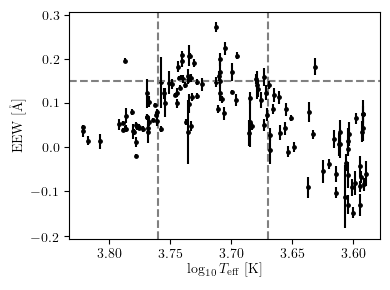

In [23]:
figure(figsize=(4, 3))
plt.errorbar(log10.(df.teff[df.inpleiades]), df.EEW[df.inpleiades], yerr=df.EEW_err[df.inpleiades], ls="", c="k")
plt.scatter(log10.(df.teff[df.inpleiades]), df.EEW[df.inpleiades], c="k", s=6)
axhline(0.15, ls="--", zorder=1, c="grey")
for lt in tcuts
    axvline(lt, ls="--", zorder=-1, c="grey")
end
xlabel(L"\log_{10}T_\mathrm{eff}~[\mathrm{K}]")
ylabel(L"EEW $[$\AA]")
gca().invert_xaxis()
tight_layout()
savefig("../../Desktop/pleiadesEEW.pdf", bbox_inches="tight")

In [ ]:
hexbin(df.teff[df.couldflag], df.logg[df.couldflag], C=df.logg[df.couldinpleiades],
    reduce_C_function=log10 ∘ length , gridsize=15, cmap="bone_r", extent=[3500, 7000, 0, 5.1], alpha=0.5)
plt.scatter(df.teff[df.inpleiades], df.logg[df.inpleiades], c=df.EEW[df.inpleiades])
colorbar()
gca().invert_yaxis()
gca().invert_xaxis()

# Kiel diagram / CMDs

In [13]:
include("masstracks.jl");

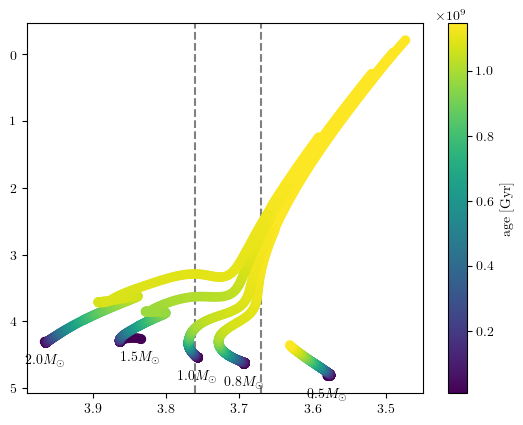

In [26]:
for (M, feh, eep) in eeps
    mask = 0 .<= eep.phase .< 3
    xs = eep.log_Teff[mask]
    ys = eep.log_g[mask]
    scatter(xs, ys, c=eep.star_age[mask])
    text(xs[1], ys[1]+0.2, LaTeXString("\$$(M) M_\\odot\$"), va="top", ha="center", color="k", size=10)
end
gca().invert_yaxis()
gca().invert_xaxis()
colorbar(label="age [Gyr]")
for lt in tcuts
    axvline(lt, ls="--", zorder=-1, c="grey")
end

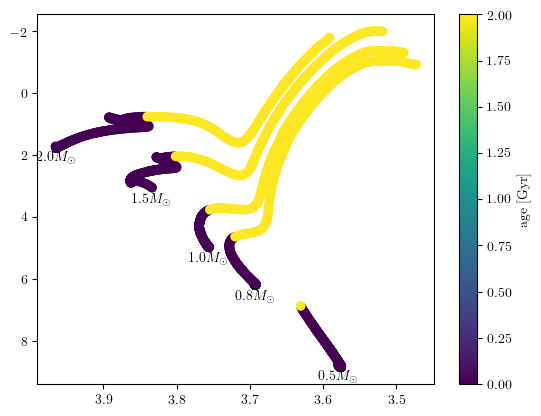

PyObject <matplotlib.colorbar.Colorbar object at 0x1e84e6190>

In [93]:
for (M, feh, eep) in eeps
    mask = 0 .<= eep.phase .< 3
    xs = eep.log_Teff[mask]
    ys = eep.G[mask]
    scatter(xs, ys, c=eep.phase[mask])
    text(xs[1], ys[1]+0.2, LaTeXString("\$$(M) M_\\odot\$"), va="top", ha="center", color="k", size=10)
end
gca().invert_yaxis()
gca().invert_xaxis()
colorbar(label="age [Gyr]")

In [27]:
include("../shenandoah/turbo.jl")

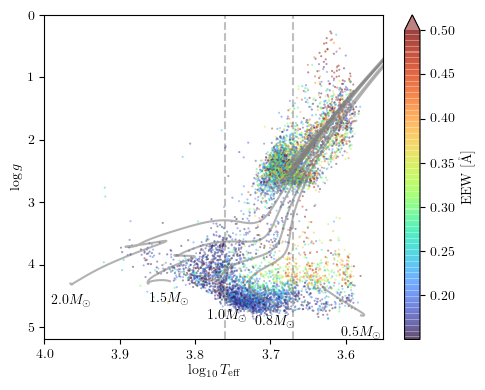

In [30]:
include("../cats/human_readable_names.jl")
figure(figsize=(5, 4))
scatter(log10.(df[df.flagged, :teff]), df[df.flagged, :logg], s=1, marker=".", c=df[df.flagged, :EEW], alpha=0.5, 
        cmap=turbo, vmax=0.5, zorder=-1)
#scatter(log10.(xiang.teff[MSTO]), xiang.logg[MSTO], s=20, zorder=10)
overplot_eep(eeps, :log_Teff, :log_g)
for lt in tcuts
    axvline(lt, ls="--", zorder=-1, c="grey", alpha=0.5)
end
gca().invert_yaxis()
gca().invert_xaxis()
colorbar(extend="max").set_label(label=hrname(:EEW))
xlim(4, 3.55)
ylim(5.2, 0.0)
xlabel(L"\log_{10} T_\mathrm{eff}")
ylabel(L"\log g")
tight_layout()
savefig("../../Desktop/kiel.pdf")

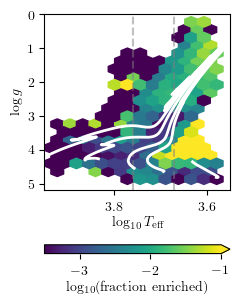

In [32]:
figure(figsize=(2.5,3.2))
censoredmean(f) = length(f) > 10 ? log10(mean(f)) : NaN
hexbin(log10.(df.teff[df.couldflag]), df.logg[df.couldflag], C=df.flagged[df.couldflag], 
    reduce_C_function=censoredmean, gridsize=20, cmap="viridis", vmin=-3.5, vmax=-1, extent=[3.95, 3.4, 0, 5.1])
colorbar(extend="max", label=L"log$_{10}$(fraction enriched)", orientation="horizontal", pad=0.2)
for lt in tcuts
    axvline(lt, ls="--", c="grey", alpha=0.5)
end
xlabel(L"\log_{10} T_\mathrm{eff}")
ylabel(L"\log g")
gca().invert_yaxis()
gca().invert_xaxis()
overplot_eep(eeps, :log_Teff, :log_g; label=false, c="w", lw=2, alpha=1)
xlim(3.95, 3.55)
ylim(5.2, 0.0)
tight_layout()
savefig("../../Desktop/frackiel.pdf", bbox_inches="tight")

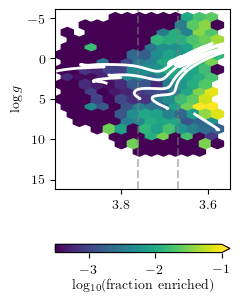

In [114]:
figure(figsize=(2.5,3.2))
censoredmean(f) = length(f) > 10 ? log10(mean(f)) : NaN
hexbin(log10.(df.teff[df.couldflag]), df.G[df.couldflag], C=df.flagged[df.couldflag], 
    reduce_C_function=censoredmean, gridsize=20, cmap="viridis", vmin=-3.5, vmax=-1, extent=[3.95, 3.4, -5, 15.1])
colorbar(extend="max", label=L"log$_{10}$(fraction enriched)", orientation="horizontal", pad=0.2)
for lt in tcuts
    axvline(lt, ls="--", c="grey", alpha=0.5)
end
#xlabel(L"\log_{10} T_\mathrm{eff}")
ylabel(L"\log g")
gca().invert_yaxis()
gca().invert_xaxis()
overplot_eep(eeps, :log_Teff, :G; label=false, c="w", lw=2, alpha=1)
xlim(3.95, 3.55)
#ylim(5.2, 0.0)
tight_layout()

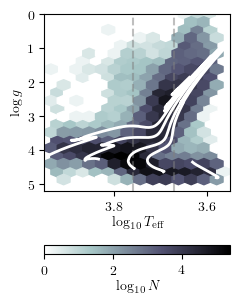

In [33]:
figure(figsize=(2.5,3.2))
hexbin(log10.(df.teff[df.couldflag]), df.logg[df.couldflag], C=df.logg[df.couldflag],
    reduce_C_function=log10 ∘ length , gridsize=20, cmap="bone_r", extent=[3.95, 3.4, 0, 5.1])
colorbar(label=L"\log_{10} N", orientation="horizontal", pad=0.2)
for lt in tcuts
    axvline(lt, ls="--", c="grey", alpha=0.5)
end
xlabel(L"\log_{10} T_\mathrm{eff}")
ylabel(L"\log g")
gca().invert_yaxis()
gca().invert_xaxis()
overplot_eep(eeps, :log_Teff, :log_g; label=false, c="w", lw=2, alpha=1)
xlim(3.95, 3.55)
ylim(5.2, 0.0)
tight_layout()
savefig("../../Desktop/allkiel.pdf", bbox_inches="tight")

# MSTO abundances

In [14]:
xiang = FITS(DataFrame ∘ last, "../cats/DDPayne_LAMOST_DR5_recommended_with_designations.fits")
xiang = join(df, xiang, on=:designation, kind=:left, makeunique=true);

In [15]:
abundance_cols = [:C_FE, :N_FE, :O_FE, :NA_FE, :MG_FE, :AL_FE, :SI_FE, :CA_FE, :TI_FE, :CR_FE, :MN_FE, :CO_FE, :NI_FE, :CU_FE, :BA_FE]
for col in abundance_cols
    xiang[(ismissing.(xiang[!, col])) .| (xiang[!, col] .== -999f0), col] .= NaN
    xiang[!, col] = Float32.(xiang[!, col])
end

In [16]:
rr = Dict("Li"=>1148, "Be"=>1551, "B"=>740, "C"=>40, "N"=>123, "O"=>183, "F"=>674, "Na"=>1035, "Mg"=>1343, "Al"=>1652, 
              "Si"=>1314, "P"=>1287, "S"=>672, "Cl"=>472, "K"=>993, "Ca"=>1535, "Sc"=>1541, "Ti"=>1565, "V"=>1370, "Cr"=>1291, 
              "Mn"=>1123, "Fe"=>1338, "Co"=>1354, "Ni"=>1363, "Cu"=>1034, "Zn"=>704, "Ga"=>1010, "Ge"=>830, "As"=>1235, 
              "Se"=>701, "Br"=>420, "Rb"=>752, "Sr"=>1548, "Y"=>1551, "Zr"=>1722, "Nb"=>1561, "Mo"=>1520, "Ru"=>1533, 
              "Rh"=>1370, "Pd"=>1330, "Ag"=>699, "Cd"=>502, "In"=>492, "Sn"=>604, "Sb"=>890, "Te"=>665, "I"=>390, "Cs"=>593, 
              "Ba"=>1423, "La"=>1615, "Ce"=>1454, "Pr"=>1550, "Nd"=>1630, "Sm"=>1545, "Eu"=>1491, "Gd"=>1630, "Tb"=>1630, 
              "Dy"=>1630, "Ho"=>1630, "Er"=>1630, "Tm"=>1630, "Yb"=>1528, "Lu"=>1630, "Hf"=>1720, "Ta"=>1546, "W"=>1736, 
              "Re"=>1736, "Os"=>1806, "Ir"=>1566, "Pt"=>1370, "Au"=>967, "Hg"=>240, "Tl"=>365, "Pb"=>495, "Bi"=>480, "Th"=>1630, "U"=>160)

refrac = Dict([Symbol(uppercase(k) * "_FE") => v for (k, v) in rr]);

In [6]:
MSTO = @. (2.9 < xiang.logg < 3.7) & (log10(xiang.teff) > 3.75);

r = rand(1:size(xiang, 1), 5000)
r = xiang.flagged
scatter(log10.(xiang.teff[r]), xiang.logg[r], c=MSTO[r], s=1, alpha=0.5)

overplot_eep(eeps, :log_Teff, :log_g)

gca().invert_yaxis()
gca().invert_xaxis()

UndefVarError: UndefVarError: xiang not defined

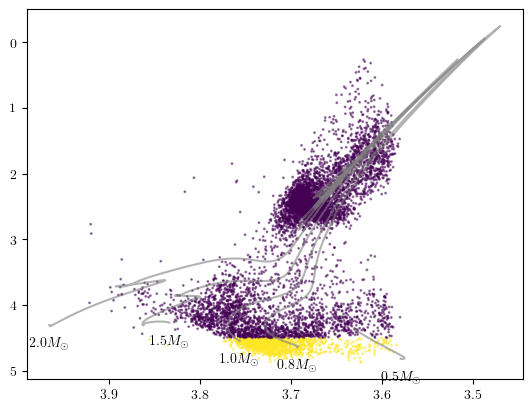

In [20]:
MSTO = @. (4.5 < df.logg) #& (log10(df.teff) > 3.75);

r = rand(1:size(df, 1), 5000)
r = df.flagged
scatter(log10.(df.teff[r]), df.logg[r], c=MSTO[r], s=1, alpha=0.5)

overplot_eep(eeps, :log_Teff, :log_g)

gca().invert_yaxis()
gca().invert_xaxis()

In [21]:
mean(df.flagged[MSTO])

0.00127997561530493

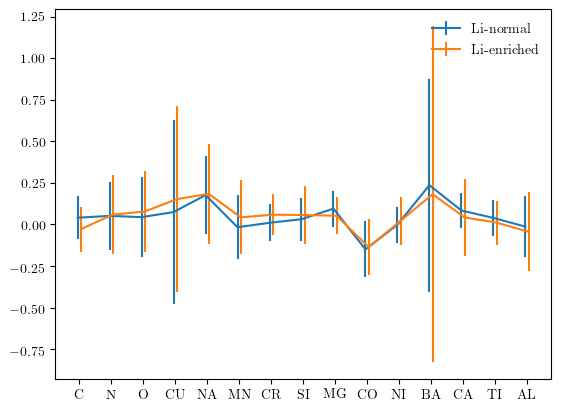

126804
376


In [61]:
using Statistics
normalMSTO = (abs.(xiang.EEW) .< 0.05) .& MSTO .& (xiang.EEW_err .< 0.05)
println(sum(normalMSTO))
enrichedMSTO = (xiang.EEW .> .15) .& MSTO .& (xiang.EEW_err .< 0.05)
println(sum(enrichedMSTO))

nanmean(a) = mean(a[(.! ismissing.(a)) .& (.! isnan.(a))])
nanscatter(a) = std(a[(.! ismissing.(a)) .& (.! isnan.(a))])
abundance_cols = [:C_FE, :N_FE, :O_FE, :NA_FE, :MG_FE, :AL_FE, :SI_FE, :CA_FE, :TI_FE, :CR_FE, :MN_FE, :CO_FE, :NI_FE, :CU_FE, :BA_FE]
#abundance_cols = [:NA_FE, :MG_FE, :AL_FE, :SI_FE, :CA_FE, :TI_FE, :CR_FE, :MN_FE, :CO_FE, :NI_FE, :CU_FE]
temps = [refrac[col] for col in abundance_cols]
p = sortperm(temps)
abundance_cols = abundance_cols[p]
temp = temps[p]

abunds = eachcol(Matrix(xiang[normalMSTO, abundance_cols]))
errorbar((1:length(abunds)) .- 0.05, nanmean.(abunds), yerr=nanscatter.(abunds), label="Li-normal")

abunds = eachcol(Matrix(xiang[enrichedMSTO, abundance_cols]))
errorbar((1:length(abunds)).+ 0.05, nanmean.(abunds), yerr=nanscatter.(abunds), label="Li-enriched")
#plot(nanmean.(eachcol(Matrix(xiang[enrichedMSTO, abundance_cols]))))

xticks(ticks=1:length(abunds), labels=first.(split.(String.(abundance_cols), "_")))
legend()
;

In [27]:
#load my abundances
using CSV
myabundances = DataFrame(CSV.read("../lamostmodel/inferred_labels_unique.csv"));
df = join(df, myabundances, on=[:designation], kind=:left, makeunique=true);

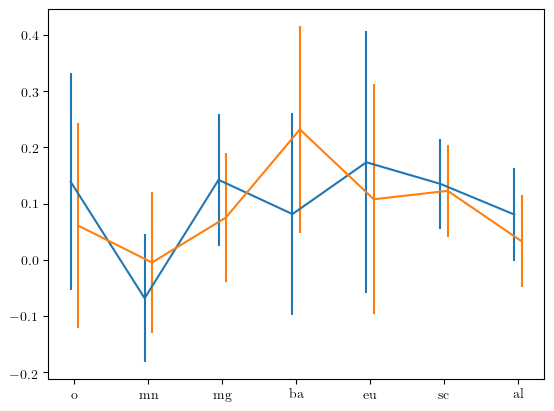

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
No handles with labels found to put in legend.


In [143]:
normalMSTO = (abs.(df.EEW) .< 0.05) .& MSTO
enrichedMSTO = df.flagged .& MSTO
;

using Statistics
nanmean(a) = mean(a[(.! ismissing.(a)) .& (.! isnan.(a))])
nanscatter(a) = std(a[(.! ismissing.(a)) .& (.! isnan.(a))])
abundance_cols = [:o_fe, :sc_fe, :eu_fe, :mg_fe, :al_fe, :mn_fe, :ba_fe]
temps = [get(refrac,Symbol(uppercase(String(col))),0) for col in abundance_cols]
p = sortperm(temps)
abundance_cols = abundance_cols[p]
temp = temps[p]

abunds = eachcol(Matrix(df[normalMSTO, abundance_cols]))
errorbar((1:length(abunds)) .- 0.05, nanmean.(abunds), yerr=nanscatter.(abunds))

abunds = eachcol(Matrix(df[enrichedMSTO, abundance_cols]))
errorbar((1:length(abunds)).+ 0.05, nanmean.(abunds), yerr=nanscatter.(abunds))

xticks(ticks=1:length(abunds), labels=first.(split.(String.(abundance_cols), "_")))
legend()
;

In [144]:
include("../cats/human_readable_names.jl")
overplot_eep(eeps, :BP_RP, :G)
scatter(df[df.flagged, :bp_rp], df[df.flagged, :G], s=1, c=df[df.flagged, :EEW], alpha=0.5, 
        cmap=turbo, vmax=0.5, zorder=10)
gca().invert_yaxis()
colorbar(extend="max").set_label(label=hrname(:EEW))
xlim(0, 3)
ylim(10, -5)
#xlabel(L"\log_{10} T_\mathrm{eff}")
#ylabel(L"\log g")
savefig("../../Desktop/CMD.pdf")

UndefVarError: UndefVarError: overplot_eep not defined

In [7]:
sum(df.flagged)

8428

In [6]:
size(df)

(4344356, 21)

#  RGB

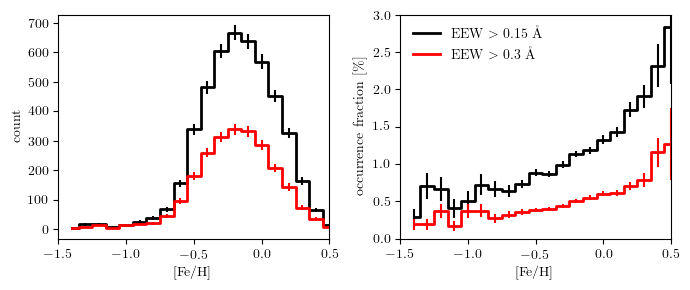

In [125]:
using StatsBase
fehbins=-1.5:0.1:0.5

gmatch = df.flagged .& (df.logg .< 2.7)
#gmatch = (df.EEW_err .< 0.033) .& (df.EEW .> 0.1) .& (df.logg .< 3)

axs = subplots(1, 2, figsize=(7,3))[2]

for (gmatch, couldflag, c, label) in [(df.flagged, df.couldflag, "k", L"EEW $> 0.15$ \AA"), 
        ((df.EEW .> 0.3) .& (df.EEW_err .< 0.3/3), (df.EEW_err .< 0.3/3), "r", L"EEW $> 0.3$ \AA")]
    h = fit(Histogram, df[gmatch .& (df.logg .< 3), :feh], fehbins)
    h2 = fit(Histogram, df[couldflag .& (df.logg .< 3), :feh], fehbins)
    midpoints = h.edges[1][1:end-1] + diff(h.edges[1])

    sca(axs[1])
    plt.errorbar(midpoints, h.weights, sqrt.(h.weights), ls="", c=c)
    plt.step(midpoints, h.weights, where="mid", lw=2, c=c)
    ylabel("count")
    xlim(-1.5, 0.5)

    sca(axs[2])
    plt.errorbar(midpoints, h.weights./h2.weights * 100, 
        sqrt.(h.weights .+ h.weights.^2 ./ h2.weights)./h2.weights * 100, ls="", c=c)
    plt.step(midpoints, h.weights./h2.weights * 100 , lw=2, where="mid", c=c, label=label)
end
legend()
ylabel("occurrence fraction [\\%]")
axs[1].set_xlabel("[Fe/H]")
axs[2].set_xlabel("[Fe/H]")
xlim(-1.5, 0.5)
ylim(0,3)
tight_layout()
savefig("../../Desktop/occurrence_rate.pdf", bbox_inches="tight")

In [126]:
sum(gmatch)

4459

### What's up with the "Li emitters"? 
They don't share a common fiber or observation day.

In [ ]:
ldr5 = FITS(DataFrame ∘ last, "../cats/LAMOST-dr5-v3-stellar.fits.gz");

In [ ]:
dateddf = join(df, ldr5[:, [:designation, :obsdate, :fiberid]], on=:designation, kind=:left);

In [ ]:
println(dateddf.obsdate[(dateddf.EEW .< -2) .& (dateddf.isline)])

In [ ]:
println(dateddf.fiberid[(dateddf.EEW .< -2) .& (dateddf.isline)])